##**Análisis descriptivo de la incidencia de los delitos informáticos en relación con el acceso a internet fijo en los departamentos de Colombia (2022-2024)**



**Descripción de necesidad**: se hace evidente la necesidad de contar con un análisis que permita comprender cómo la expansión del acceso a internet fijo en los distintos departamentos del país puede estar relacionada con el comportamiento de los delitos informáticos. La ausencia de estudios que integren variables de conectividad y criminalidad digital desde una perspectiva territorial limita la capacidad del Estado para formular respuestas preventivas, focalizadas y basadas en evidencia. Por ello, el desarrollo de un proyecto de analítica de datos que describa la incidencia de los delitos informáticos en relación con el acceso a internet fijo entre 2022 y 2024, permitirá identificar patrones, correlaciones y zonas de mayor vulnerabilidad, contribuyendo a fortalecer la toma de decisiones en políticas públicas de seguridad digital y transformación digital con enfoque diferencial y territorial.

**Objetivo**: Analizar de forma descriptiva la relación entre la conectividad a internet fijo y la incidencia (tipo, región y año) de los delitos informáticos en los departamentos de Colombia entre 2022 y 2024.

##**Juntar la información de trabajo en un solo Dataframe**

# **Información conectada a datos abiertos**

# **Cargar Información del geoportal**

En esta primera parte del proyecto se cargan y preparan los datos geográficos del DANE, necesarios para identificar correctamente los códigos de cada departamento y municipio en Colombia. Primero, se importa la información desde un archivo Excel alojado en GitHub que contiene la codificación territorial oficial. Luego, se ajusta la estructura del archivo estableciendo los nombres correctos de las columnas, eliminando filas y columnas innecesarias, y creando una columna llamada Dep_Mpio, que funciona como una llave única al combinar el nombre del departamento y municipio. Finalmente, se eliminan duplicados y se define esa llave como índice del DataFrame, lo cual permitirá más adelante cruzar esta información con la base de datos de delitos y ubicar cada caso en su región correspondiente.

La base de datos utilizadas fue: Dane - Geoportal - .CSV https://geoportal.dane.gov.co/geovisores/territorio/consulta-divipola-division-politico-administrativa-de-colombia/

In [ ]:
# ===================================
# 1. LIBRERÍAS
# ===================================
import pandas as pd
import chardet

# ===================================
# 2. CARGAR DATOS DE FORMA MANUAL
# ===================================
url= 'https://github.com/DianaCorreaOrtiz/project_bootcamp/raw/refs/heads/main/Geoportal%20del%20DANE%20-%20Codificaci%C3%B3n%20Divipola.xlsx'
df_geoespacio = pd.read_excel(url)

# ===================================
# 3. AJUSTAR DATOS
# ===================================
# Renombrando títulos
df_geoespacio.columns = df_geoespacio.iloc[0].values

# Eliminar la fila 1
df = df_geoespacio.drop(0).reset_index(drop=True)

#Agregar columna llave
df_geoespacio['Dep_Mpio'] = df_geoespacio ['Nombre Departamento'] + df_geoespacio ['Nombre Municipio']

#Quitar duplicados
df_geoespacio.drop_duplicates(subset= 'Dep_Mpio',inplace=True)

#Colocar la llave como Indice
df_geoespacio.set_index ('Dep_Mpio', inplace= True)

#Eliminar columnas inncesarias
df_geoespacio.drop (['Nombre Centro Poblado', 'Tipo Centro Poblado', 'Nombre Distrito', 'Municipio/Áreas No Municipalizadas (ANM)', 'Nombre Área Metropolitana', 'Código Centro Poblado', 'Longitud', 'Latitud'], axis = 1, inplace= True)
df_geoespacio

,Código Departamento,Código Municipio,Nombre Departamento,Nombre Municipio
Dep_Mpio,,,,
Nombre DepartamentoNombre Municipio,Código Departamento,Código Municipio,Nombre Departamento,Nombre Municipio
ANTIOQUIAMEDELLÍN,05,05001,ANTIOQUIA,MEDELLÍN
ANTIOQUIAABEJORRAL,05,05002,ANTIOQUIA,ABEJORRAL
ANTIOQUIAABRIAQUÍ,05,05004,ANTIOQUIA,ABRIAQUÍ
ANTIOQUIAALEJANDRÍA,05,05021,ANTIOQUIA,ALEJANDRÍA
...,...,...,...,...
VAUPÉSYAVARATÉ (ANM),97,97889,VAUPÉS,YAVARATÉ (ANM)
VICHADAPUERTO CARREÑO,99,99001,VICHADA,PUERTO CARREÑO
VICHADALA PRIMAVERA,99,99524,VICHADA,LA PRIMAVERA


In [ ]:
#df_geoespacio.to_excel("resultados.xlsx", index=False)

# **Carga de la tabla de delitos**

En esta parte del proyecto se descargan los datos de delitos informáticos reportados en Colombia entre los años 2022 y 2024, utilizando una API pública del portal de datos abiertos del gobierno. Para lograrlo, se hace una consulta por año y en bloques de 1000 registros, filtrando exclusivamente los casos clasificados como “delitos informáticos” ocurridos en Colombia. Los datos se van almacenando progresivamente hasta completar la descarga, y luego se consolidan en un DataFrame. Esta información será clave para analizar la distribución de estos delitos por región y año, y así establecer patrones relacionados con el acceso a internet.
La base de datos utilizada fue: Fiscalía General de la Nación  - .JSON
https://www.datos.gov.co/Justicia-y-Derecho/Conteo-de-Procesos-V2/6d52-qyqg/about_data

In [ ]:
# ===================================
# 1. LIBRERÍAS
# ===================================
import pandas as pd
import requests

# ===================================
# 2. DESCARGAR DATOS DELITOS
# ===================================
base_url = "https://www.datos.gov.co/resource/6d52-qyqg.json"
anios = [2022, 2023, 2024]
lote = 1000
datos = []

print("Iniciando descarga filtrada por año y país...")

for anio in anios:
    offset = 0
    while True:
        params = {
            "$limit": lote,
            "$offset": offset,
            "$where": f"a_o_hechos = '{anio}' AND pais_hecho = 'Colombia' AND grupo_delito = 'DELITOS INFORMATICOS'"
        }
        response = requests.get(base_url, params=params)
        if response.status_code != 200:
            print(f"Error {response.status_code} en año {anio}, offset {offset}")
            break

        data = response.json()
        if not data:
            break

        datos.extend(data)
        offset += lote
        print(f"Año {anio} - registros descargados: {offset}")

print("Descarga completa.")
df_delitos = pd.DataFrame(datos)
print(f"\nTotal de registros filtrados: {len(df_delitos)}")

# ===================================
# 3. RENOMBRAR COLUMNAS
# ===================================
nuevos_nombres_columna = {
    "criminalidad" :  "Criminalidad",
    "es_archivo" :  "Es_Archivo",
    "es_preclusion" :  "Es_Preclusion",
    "estado" :  "Estado",
    "etapa_caso" :  "Etapa_Caso",
    "ley" :  "Ley",
    "departamento_hecho" :  "Departamento_Hecho",
    "municipio_hecho" :  "Municipio_Hecho",
    "seccional" :  "Seccional",
    "a_o_hechos" :  "Año_Hechos",
    "a_o_entrada" :  "Año_Entrada",
    "a_o_denuncia" :  "Año_Denuncia",
    "delito" :  "Delito",
    "grupo_delito" :  "Grupo_Delito",
    "consumado" :  "Consumado"
}
df_delitos.rename(columns=nuevos_nombres_columna, inplace=True)

# ===================================
# 4. CARGAR ARCHIVO DE CORRECCIONES
# ===================================
url = 'https://github.com/DianaCorreaOrtiz/project_bootcamp/raw/refs/heads/main/Nuevos_Dep_Mpio.xlsx'
df_correcciones = pd.read_excel(url)

# Normalizar texto para unir correctamente
for col in ['Departamento_Hecho', 'Municipio_Hecho']:
    df_delitos[col] = df_delitos[col].astype(str).str.upper().str.strip()

for col in ['Nombre Departamento', 'Nombre Municipio']:
    df_correcciones[col] = df_correcciones[col].astype(str).str.upper().str.strip()

# ===================================
# 5. UNIR Y REEMPLAZAR DATOS
# ===================================
df_delitos = df_delitos.merge(
    df_correcciones,
    left_on=['Departamento_Hecho', 'Municipio_Hecho'],
    right_on=['Nombre Departamento', 'Nombre Municipio'],
    how='left'
)

# Usar las columnas corregidas si existen, o mantener las originales
df_delitos['Departamento_Final'] = df_delitos['Departamento_Corregido'].combine_first(df_delitos['Departamento_Hecho'])
df_delitos['Municipio_Final'] = df_delitos['Municipio_Corregido'].combine_first(df_delitos['Municipio_Hecho'])

# Crear nueva llave corregida
df_delitos['Dep_Mpio'] = df_delitos['Departamento_Final'] + df_delitos['Municipio_Final']

#Borrar columnas innecesarias
df_delitos = df_delitos.drop (['Departamento_Hecho', 'Municipio_Hecho', 'pais_hecho', 'Departamento_Final', 'Municipio_Final', 'Nombre Departamento', 'Nombre Municipio'], axis = 1)

#Renombrar Departamento y Municipio
nuevos_nombres_columna = {
    "Departamento_Corregido" :  "Departamento_Hecho",
    "Municipio_Corregido" :  "Municipio_Hecho"
}
df_delitos.rename(columns=nuevos_nombres_columna, inplace=True)

#Colocar la llave como Indice
df_delitos.set_index ('Dep_Mpio', inplace= True)

# ===================================
# 6. UNIR CON TABLA GEOESPACIO
# ===================================
df_delitos = df_delitos.join (df_geoespacio)

#Borrar columnas innecesarias
df_delitos = df_delitos.drop (['Nombre Departamento', 'Nombre Municipio'], axis = 1)

#Convertir columnas numéricas a texto
df_delitos['Código Departamento'] = df_delitos['Código Departamento'].astype(int).astype(str)
df_delitos['Código Municipio'] = df_delitos['Código Municipio'].astype(int).astype(str)


#Crear nueva columna de codigo departamento y municipio
df_delitos['Cod__Anno_Dep_Mpio'] = df_delitos['Año_Hechos'].astype(str) + df_delitos['Código Departamento'] + df_delitos['Código Municipio']

# ===================================
# 7. CAMBIAR INDICE
# ===================================
df_delitos.set_index('Cod__Anno_Dep_Mpio', inplace= True)
df_delitos

Iniciando descarga filtrada por año y país...
Año 2022 - registros descargados: 1000
Año 2022 - registros descargados: 2000
Año 2022 - registros descargados: 3000
Año 2022 - registros descargados: 4000
Año 2022 - registros descargados: 5000
Año 2022 - registros descargados: 6000
Año 2022 - registros descargados: 7000
Año 2022 - registros descargados: 8000
Año 2023 - registros descargados: 1000
Año 2023 - registros descargados: 2000
Año 2023 - registros descargados: 3000
Año 2023 - registros descargados: 4000
Año 2023 - registros descargados: 5000
Año 2023 - registros descargados: 6000
Año 2023 - registros descargados: 7000
Año 2023 - registros descargados: 8000
Año 2024 - registros descargados: 1000
Año 2024 - registros descargados: 2000
Año 2024 - registros descargados: 3000
Año 2024 - registros descargados: 4000
Año 2024 - registros descargados: 5000
Año 2024 - registros descargados: 6000
Año 2024 - registros descargados: 7000
Año 2024 - registros descargados: 8000
Descarga completa.

,Criminalidad,Es_Archivo,Es_Preclusion,Estado,Etapa_Caso,Ley,Seccional,Año_Hechos,Año_Entrada,Año_Denuncia,Delito,Grupo_Delito,Consumado,total_procesos,Departamento_Hecho,Municipio_Hecho,Código Departamento,Código Municipio
Cod__Anno_Dep_Mpio,,,,,,,,,,,,,,,,,,
202255360,SI,SI,NO,INACTIVO,INDAGACIÓN,Ley 906,DIRECCIÓN SECCIONAL DE MEDELLÍN,2022,2022,2022,HURTO POR MEDIOS INFORMATICOS Y SEMEJANTES ART...,DELITOS INFORMATICOS,NO APLICA,161,ANTIOQUIA,ITAGÜÍ,5,5360
20222323417,SI,SI,NO,INACTIVO,INDAGACIÓN,Ley 906,DIRECCIÓN SECCIONAL DE CÓRDOBA,2022,2022,2022,ACCESO ABUSIVO A UN SISTEMA INFORMATICO ART 26...,DELITOS INFORMATICOS,NO APLICA,5,CÓRDOBA,LORICA,23,23417
20221111001,SI,NO,NO,INACTIVO,INDAGACIÓN,Ley 906,DIRECCIÓN SECCIONAL DE BOGOTÁ,2022,2022,2022,TRANSFERENCIA NO CONSENTIDA DE ACTIVOS VALIEND...,DELITOS INFORMATICOS,NO APLICA,17,NaN,NaN,11,11001
20227676001,SI,SI,NO,INACTIVO,INDAGACIÓN,Ley 906,DIRECCIÓN SECCIONAL DE CALI,2022,2022,2022,"INTERCEPTACION DE DATOS INFORMATICOS, ART 269C...",DELITOS INFORMATICOS,NO APLICA,6,VALLE DEL CAUCA,SANTIAGO DE CALI,76,76001
20227676622,NO,SI,NO,INACTIVO,INDAGACIÓN,Ley 906,DIRECCIÓN SECCIONAL DE VALLE DEL CAUCA,2022,2022,2022,VIOLACION DE DATOS PERSONALES ART 269F LEY 127...,DELITOS INFORMATICOS,NO APLICA,5,VALLE DEL CAUCA,ROLDANILLO,76,76622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20241818785,NO,SI,NO,INACTIVO,INDAGACIÓN,Ley 906,DIRECCIÓN SECCIONAL DE CAQUETÁ,2024,2024,2024,HURTO POR MEDIOS INFORMATICOS Y SEMEJANTES ART...,DELITOS INFORMATICOS,NO APLICA,1,CAQUETÁ,SOLITA,18,18785
20245050370,SI,SI,NO,INACTIVO,INDAGACIÓN,Ley 906,DIRECCIÓN SECCIONAL DE META,2024,2024,2024,ACCESO ABUSIVO A UN SISTEMA INFORMATICO ART 26...,DELITOS INFORMATICOS,NO APLICA,1,META,URIBE,50,50370
20241919824,SI,NO,NO,INACTIVO,INDAGACIÓN,Ley 906,DIRECCIÓN SECCIONAL DE CAUCA,2024,2024,2024,VIOLACION DE DATOS PERSONALES ART 269F LEY 127...,DELITOS INFORMATICOS,NO APLICA,1,CAUCA,TOTORÓ,19,19824


Al finalizar el proceso de limpieza, normalización y cruce de datos, se genera un DataFrame consolidado con los delitos informáticos ocurridos en Colombia entre 2022 y 2024, organizados por año, departamento y municipio. Este resultado puede ser exportado a un archivo Excel para su análisis externo, visualización o almacenamiento. La línea comentada indica cómo realizar esta exportación si se requiere guardar el archivo localmente con todos los registros estructurados.

In [ ]:
#df_delitos.to_excel("delitos.xlsx", index= True)

# **Cargar tabla de Conectividad y Censo Dane**

En esta sección se carga una base de datos adicional que contiene información sobre el acceso a internet (conectividad) y datos poblacionales del censo por departamento y municipio. Esta tabla proviene de una fuente oficial (DANE) y permite asociar a cada región no solo la ubicación geográfica, sino también variables claves como número de hogares conectados, porcentaje de acceso a internet, y población estimada. Una vez cargada, esta tabla se une con la base de delitos a través de una llave común (Dep_Mpio), lo cual permite enriquecer el análisis final al cruzar variables sociales y tecnológicas con la ocurrencia de delitos informáticos. La base de datos usada fue: Observatorio Nacional de Tecnologías de la Información y las Comunicaciones. - .XLSX https://ontic.mintic.gov.co/857/w3-propertyvalue-916082.html#data=%7B%22orfilter%22:%22753959%22,%22page%22:1%7D

In [ ]:
from collections import UserList
# ===================================
# 1. LIBRERÍAS
# ===================================
#pip install gspread pandas gdown oauth2client
import pandas as pd
import chardet
import gdown

# ===================================
# 2. CARGAR DATOS DESDE GITHUB
# ===================================
url= 'https://github.com/DianaCorreaOrtiz/project_bootcamp/raw/refs/heads/main/TIC%20en%20Colombia%20Vs%20Censo.xlsx'
df_conectividad_censo = pd.read_excel(url)

# ===================================
# 3. RENOMBRAR TITULO Y BORRAR FILAS INNECESARIAS
# ===================================
# Renombrando títulos
df_conectividad_censo.columns = df_conectividad_censo.iloc[4].values

# Eliminar los primeros 5 registros
df_conectividad_censo = df_conectividad_censo.drop([0, 1, 2, 3, 4]).reset_index(drop=True)

# ===================================
# 4. RENOMBRAR COLUMNAS
# ===================================
# Cambiar por posición
nuevos_nombres = list(df_conectividad_censo.columns)

nuevos_nombres[0] = 'Año'
nuevos_nombres[1] = 'Trimestre'
nuevos_nombres[2] = 'Código Departamento' # Primer 'CÓDIGO DANE'
nuevos_nombres[3] = 'Departamento'
nuevos_nombres[4] = 'Código Municipio'    # Segundo 'CÓDIGO DANE'
nuevos_nombres[5] = 'Municipio'
nuevos_nombres[6] = 'No. Accesos Fijos A Internet'
nuevos_nombres[7] = 'Población Dane'
nuevos_nombres[8] = 'Penetración (%)'

df_conectividad_censo.columns = nuevos_nombres

# ===================================
# 5. AJUSTAR DATOS
# ===================================
#Cambiar de posisción columnas
df_conectividad_censo[['Población Dane', 'No. Accesos Fijos A Internet']] = \
df_conectividad_censo[['No. Accesos Fijos A Internet', 'Población Dane']]

#Ajustar departamento con nombre largo)
df_conectividad_censo.loc[df_conectividad_censo['Departamento'] == 'ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANTA CATALINA', 'Departamento'] = 'SAN ANDRES Y PROVIDENCIA'

#Agrupar por promedio de Poblacion Dane y No. Accesos Fijos A Internet
df_conectividad_censo = df_conectividad_censo.groupby(['Año', 'Código Departamento', 'Departamento', 'Código Municipio', 'Municipio'], as_index=False).agg({'Población Dane': 'mean', 'No. Accesos Fijos A Internet': 'mean'})

#Convertir columnas numéricas a texto
df_conectividad_censo['Código Departamento'] = df_conectividad_censo['Código Departamento'].astype(int).astype(str)
df_conectividad_censo['Código Municipio'] = df_conectividad_censo['Código Municipio'].astype(int).astype(str)

#Agregar columna llave
df_conectividad_censo['Cod__Anno_Dep_Mpio'] = df_conectividad_censo ['Año'].astype(str) + df_conectividad_censo ['Código Departamento'] + df_conectividad_censo ['Código Municipio']

#Agregar índice Cod_Dep_Mpio
df_conectividad_censo.set_index('Cod__Anno_Dep_Mpio', inplace= True)

df_conectividad_censo

,Año,Código Departamento,Departamento,Código Municipio,Municipio,Población Dane,No. Accesos Fijos A Internet
Cod__Anno_Dep_Mpio,,,,,,,
202255001,2022,5,ANTIOQUIA,5001,MEDELLÍN,753015.0,2572350.0
202255002,2022,5,ANTIOQUIA,5002,ABEJORRAL,2374.666667,21109.0
202255004,2022,5,ANTIOQUIA,5004,ABRIAQUÍ,151.0,2804.0
202255021,2022,5,ANTIOQUIA,5021,ALEJANDRÍA,261.0,4874.0
202255030,2022,5,ANTIOQUIA,5030,AMAGÁ,3565.333333,31851.0
...,...,...,...,...,...,...,...
20249797889,2024,97,VAUPÉS,97889,YAVARATÉ,11.75,1233.0
20249999001,2024,99,VICHADA,99001,PUERTO CARREÑO,1934.5,22614.0
20249999524,2024,99,VICHADA,99524,LA PRIMAVERA,163.0,11205.0


In [ ]:
#df_conectividad_censo.to_excel("conetividad_censo.xlsx", index= True)

# **Unión de tablas agrupadas Censo y Conectividad - Tabla Delitos**

En este paso se realiza la unión definitiva entre la base de delitos informáticos y la tabla de georreferenciación del DANE utilizando la llave común Dep_Mpio. A través de esta unión, cada registro de delito queda vinculado con sus respectivos códigos de departamento y municipio oficiales. Luego, se eliminan columnas que ya no son necesarias tras la fusión y se convierten los códigos territoriales a formato texto para mantener la coherencia en el tipo de dato. Finalmente, se crea una nueva columna llamada Cod_Anno_Dep_Mpio, que concatena el año del hecho con los códigos de departamento y municipio, generando una clave única por ubicación y periodo. Esta nueva columna facilita la organización, filtrado y posterior análisis de la información tanto por región como por año.

In [ ]:
# ===================================
# 1. LIBRERÍAS
# ===================================
import pandas as pd
import chardet

# ===================================
# 2. TRAER TABLA DELITOS Y AGRUPAR
# ===================================
df_delitos_agrupada = df_delitos

#Cambiar a entero columna Total Procesos
df_delitos_agrupada['total_procesos'] = df_delitos_agrupada['total_procesos'].astype(int)


#Agrupar Delitos_Agrupada
df_delitos_agrupada = df_delitos_agrupada.groupby (['Cod__Anno_Dep_Mpio'])['total_procesos'].sum()

#Convertir df_delitos_agrupada en dataframe
df_delitos_agrupada = df_delitos_agrupada.to_frame()

# =============================================
# 3. UNIR TABLAS CENSO CONECTIVIDAD - DELITOS
# =============================================
df_union_cc_td = df_delitos_agrupada.join(df_conectividad_censo)


#Redondear columnas
df_union_cc_td['Población Dane'] = df_union_cc_td['Población Dane'].astype(float).round().astype(int)
df_union_cc_td['No. Accesos Fijos A Internet'] = df_union_cc_td['No. Accesos Fijos A Internet'].astype(float).round().astype(int)

#Renombrar columnas
nuevos_nombres = list(df_union_cc_td.columns)
nuevos_nombres[6] = 'No. Accesos Fijos A Internet'
nuevos_nombres[7] = 'Población Dane'

df_union_cc_td.columns = nuevos_nombres

#Crear el DF
df_union_cc_td = pd.DataFrame(df_union_cc_td)
df_union_cc_td

,total_procesos,Año,Código Departamento,Departamento,Código Municipio,Municipio,No. Accesos Fijos A Internet,Población Dane
Cod__Anno_Dep_Mpio,,,,,,,,
20221111001,20842,2022,11,BOGOTÁ D.C.,11001,"BOGOTÁ, D.C.",2260104,7873316
20221313001,1345,2022,13,BOLÍVAR,13001,CARTAGENA,193274,1043185
20221313006,1,2022,13,BOLÍVAR,13006,ACHÍ,133,26741
20221313042,3,2022,13,BOLÍVAR,13042,ARENAL,564,7853
20221313052,21,2022,13,BOLÍVAR,13052,ARJONA,2797,74773
...,...,...,...,...,...,...,...,...
20249797001,7,2024,97,VAUPÉS,97001,MITÚ,646,34886
20249797161,1,2024,97,VAUPÉS,97161,CARURU,36,3600
20249999001,18,2024,99,VICHADA,99001,PUERTO CARREÑO,1934,22614


In [ ]:
#df_union_cc_td.to_excel('union.xlsx', index=False)

# **Gráficos**


# **Total de procesos por año**

Este gráfico de barras muestra la cantidad total de procesos registrados por año entre 2022 y 2024 relacionados con delitos informáticos. Para ello, se agruparon los datos por año y se sumó la columna total_procesos. La visualización permite observar el comportamiento anual de estos delitos, evidenciando un aumento progresivo en el número de casos reportados. En particular, se destaca el año 2024 como el de mayor número de procesos, lo cual podría estar vinculado al crecimiento en el acceso a internet, la digitalización de trámites o una mayor capacidad institucional para registrar y responder ante este tipo de conductas delictivas. Los colores diferenciados por año facilitan la comparación visual entre periodos.

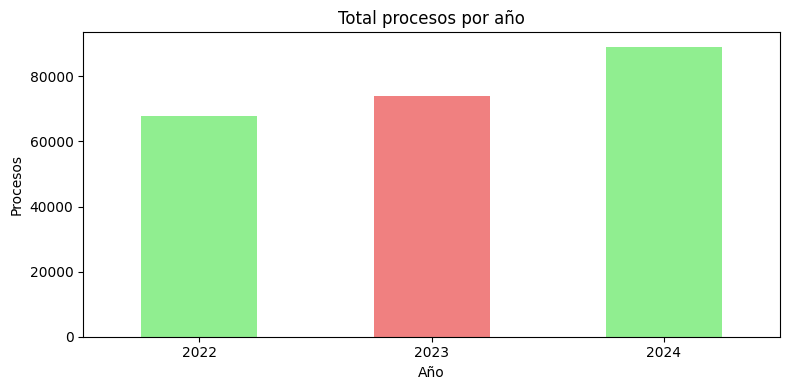

In [ ]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Crear el DF para gráficos
df_grafico_1 = df_union_cc_td.groupby (['Año'])['total_procesos'].sum()


plt.figure(figsize=(8, 4))
df_grafico_1.plot(kind='bar', color=['lightgreen', 'lightcoral'], title='Total procesos por año')
plt.ylabel('Procesos')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# **Cantidad de procesos por departamento**

Este gráfico de barras horizontales presenta la cantidad total de procesos judiciales relacionados con delitos informáticos, agrupados por departamento y acumulados entre 2022 y 2024. Para construirlo, se sumaron los procesos de cada entidad territorial y se ordenaron de mayor a menor. La visualización permite identificar de forma clara cuáles departamentos concentran el mayor número de casos. Se destaca Bogotá D.C. como el territorio con más procesos registrados, seguido por Antioquia, Valle del Cauca y Cundinamarca. Estos resultados pueden estar relacionados tanto con el tamaño de la población como con el nivel de conectividad en estas regiones, además de una mayor capacidad institucional para tramitar estos delitos. El uso de colores variados mejora la lectura visual de la distribución regional.

/tmp/ipython-input-20-1694682207.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




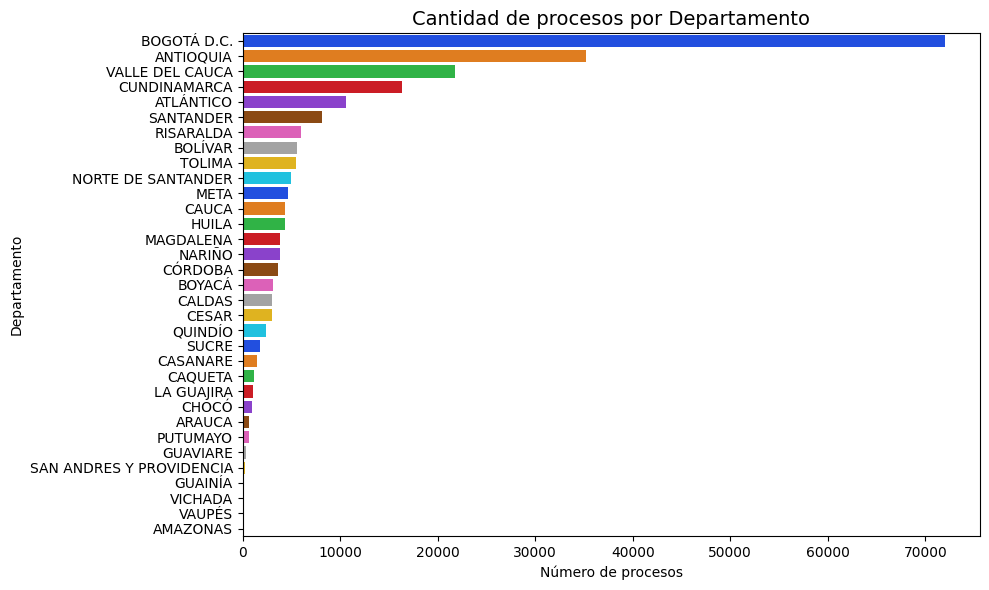

In [ ]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar, sumar y convertir a DataFrame
df_grafico_2 = (
    df_union_cc_td
    .groupby('Departamento')['total_procesos'].sum()
    .sort_values(ascending=False)
    .reset_index()  # <- Convierte Serie en DataFrame con columnas: Departamento y total_procesos
)

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=df_grafico_2, x='total_procesos', y='Departamento', palette='bright')
plt.title('Cantidad de procesos por Departamento', fontsize=14)
plt.xlabel('Número de procesos')
plt.ylabel('Departamento')
plt.tight_layout()
plt.show()

# **Relación entre censo DANE, conectividad y proceso por delitos informáticos**

Este gráfico de dispersión interactivo permite visualizar de forma integrada la relación entre el número total de procesos judiciales por delitos informáticos, la población estimada por el DANE y el nivel de conectividad (medido por accesos fijos a internet) en cada departamento. En el eje X se representa la cantidad total de procesos, en el eje Y la población, el tamaño de cada burbuja indica el nivel de conectividad, y el color diferencia el año del registro. Cada punto corresponde a un departamento. Esta visualización facilita identificar patrones: por ejemplo, las regiones con mayor población y mayor acceso a internet tienden también a registrar más procesos por delitos informáticos.

In [ ]:
import plotly.express as px

# Gráfico de dispersión interactivo
fig = px.scatter(
    df_union_cc_td,
    x='total_procesos',
    y='Población Dane',
    color='Año',
    size='No. Accesos Fijos A Internet',
    hover_name='Departamento',
    title='Relación entre delito procesos, censo dane y conectividad'
)

fig.show()

# **Relación entre procesos judiciales, población y conectividad (sin Bogotá)**

En este gráfico de dispersión interactivo se analiza la relación entre el número total de procesos judiciales por delitos informáticos, la población estimada por el DANE y el número de accesos fijos a internet en los departamentos de Colombia. Se excluye a Bogotá con el fin de concentrar la atención en las cifras de los demás departamentos. Cada punto representa un departamento en un año determinado, donde el eje X muestra los procesos, el eje Y la población, el color diferencia los años y el tamaño del punto refleja el nivel de conectividad. Esta visualización permite explorar cómo se distribuyen los delitos en función del tamaño poblacional y del acceso a internet, facilitando la identificación de patrones o posibles correlaciones entre estas variables.

In [ ]:
#df realizando el filtro de Bogota
df_filtrado_bog = df_union_cc_td[df_union_cc_td['Departamento'] != 'BOGOTÁ D.C.']

import plotly.express as px

# Gráfico de dispersión interactivo
fig = px.scatter(
    df_filtrado_bog,
    x='total_procesos',
    y='Población Dane',
    color='Año',
    size='No. Accesos Fijos A Internet',
    hover_name='Departamento',
    title='Relación entre delito procesos, censo dane y conectividad, sin tener en cuenta Bogotá'
)

fig.show()

# **Conclusión Parcial**

A partir del análisis realizado, se identifican patrones significativos en la distribución y comportamiento de los delitos informáticos en Colombia durante el periodo 2022–2024. Los resultados muestran una tendencia creciente en la cantidad de procesos judiciales por año, lo cual puede estar relacionado tanto con el aumento de la conectividad como con una mayor capacidad institucional para registrar este tipo de delitos. Al analizar la información por departamento, se observa que las regiones más pobladas y conectadas, como Bogotá, Antioquia y Valle del Cauca, concentran la mayoría de los casos. Esto sugiere una posible relación entre el nivel de acceso a internet fijo de una región y su exposición a riesgos cibernéticos. Finalmente, el gráfico de dispersión evidencia cómo la densidad poblacional, el acceso a internet y los procesos judiciales tienden a estar interconectados, lo que refuerza la importancia de fortalecer las políticas públicas de ciberseguridad y prevención en aquellas zonas con mayor conectividad fija a internet.

# **Comparación entre población y acceso a internet por departamento**

Este gráfico de barras comparativas permite observar de manera simultánea la población estimada según el censo DANE (barras azules) y el número de accesos fijos a internet en cada departamento del país (barras naranjas). Así, es posible visualizar que a mayor cantidad de población, mayor número de personas tienen acceso a internet fijo. Se destaca Bogotá D.C. por ser la entidad con mayor población y también con el mayor número de accesos fijos, seguida por Antioquia y Valle del Cauca.

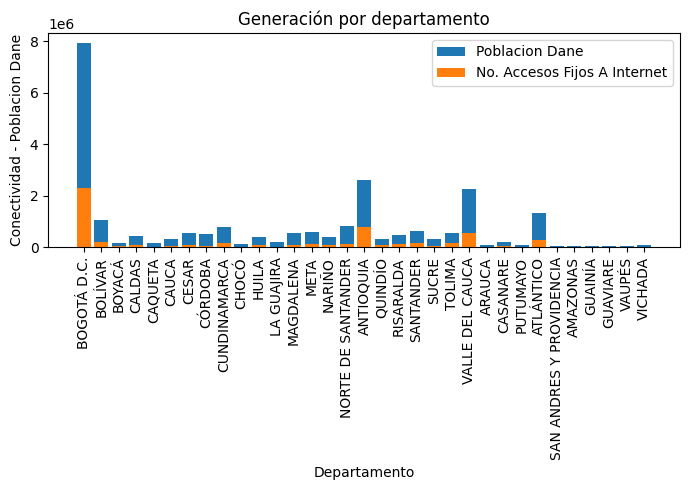

In [ ]:
# Gráfico con plt.bar(x, y, etiqueta, color/transparencia)
plt.figure(figsize=(7,5))
plt.bar(df_union_cc_td['Departamento'].astype(str), df_union_cc_td['Población Dane'], label='Poblacion Dane')
plt.bar(df_union_cc_td['Departamento'].astype(str), df_union_cc_td['No. Accesos Fijos A Internet'], label='No. Accesos Fijos A Internet')
plt.legend()
plt.title('Generación por departamento')
plt.xlabel('Departamento')
plt.ylabel('Conectividad - Poblacion Dane')


plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# **Comparación entre conectividad y procesos por departamento (sin Bogotá D.C.)**

Aquí se compara el número de accesos fijos a internet y la cantidad de procesos judiciales por delitos informáticos en los departamentos de Colombia, excluyendo a Bogotá D.C. debido a su alto volumen poblacional y de conectividad, que podría ocultar las dinámicas del resto del país. Al remover Bogotá, se logra una visualización más equilibrada y detallada del comportamiento en los demás territorios. Por ejemplo, algunos departamentos como Antioquia, Valle del Cauca o Santander muestran altos niveles tanto de conectividad como de procesos, mientras que otros al tener menor conectividad hay menos procesos.

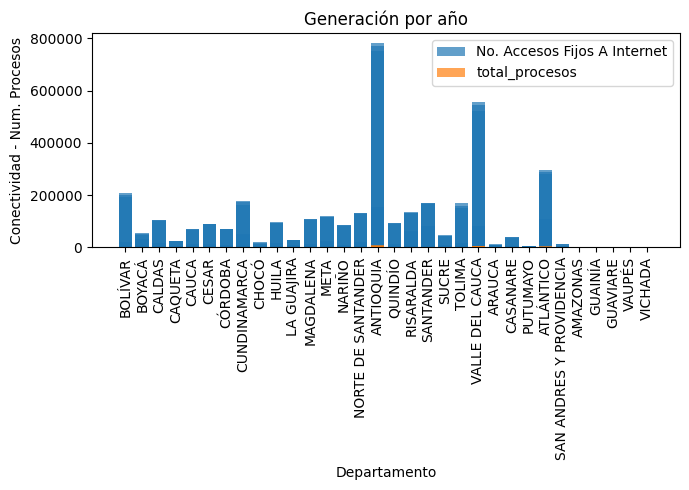

In [ ]:
# Filtrar el DataFrame sin Bogotá por que su rango es mucho mayor que los demás departamentos
df_filtrado = df_union_cc_td[df_union_cc_td['Departamento'] != 'BOGOTÁ D.C.']

# Crear el gráfico
plt.figure(figsize=(7,5))
plt.bar(df_filtrado['Departamento'], df_filtrado['No. Accesos Fijos A Internet'], label='No. Accesos Fijos A Internet', alpha=0.7)
plt.bar(df_filtrado['Departamento'], df_filtrado['total_procesos'], label='total_procesos', alpha=0.7)

plt.legend()
plt.title('Generación por año')
plt.xlabel('Departamento')
plt.ylabel('Conectividad - Num. Procesos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

##*Se deja bogotá por fuera de este gráfico, puesto que sus datos son demasiado grandes con respecto al resto de los Departamentos*

# **Distribución general de variables numéricas del conjunto de datos**

Este conjunto de histogramas presenta la distribución de tres variables numéricas fundamentales del análisis: el total de procesos judiciales por delitos informáticos, el número de accesos fijos a internet y la población estimada por el DANE, todos agregados por departamento. La visualización permite identificar la forma de la distribución de los datos, detectando concentraciones, asimetrías y posibles valores atípicos. En los tres casos se observa una distribución sesgada a la derecha (asimetría positiva), lo que indica que la mayoría de los departamentos tienen valores bajos en comparación con unos pocos casos con cifras muy elevadas. Esta información es útil para comprender el comportamiento general de las variables, anticipar necesidades de normalización y valorar la representatividad de los datos en futuros análisis o modelos.

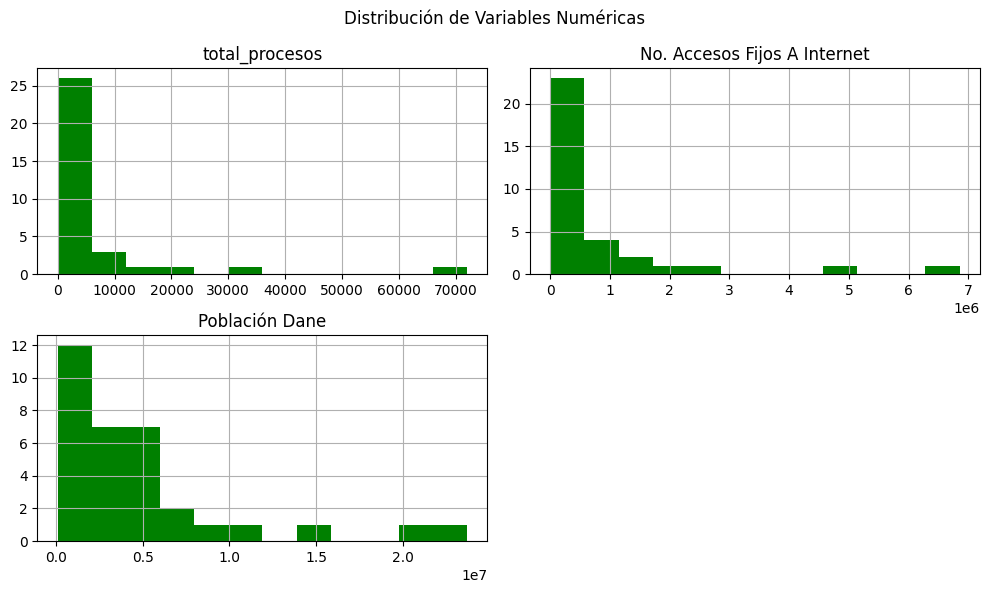

In [ ]:
#Creamos un nuevo DF y lo agrupamos por Departamento
df_grafico_3 = df_union_cc_td
df_grafico_3 = df_grafico_3.groupby(['Departamento'], as_index=False).agg({'Población Dane': 'sum', 'No. Accesos Fijos A Internet': 'sum', 'total_procesos': 'sum'})
df_grafico_3 = pd.DataFrame(df_grafico_3)

# Seleccionar columnas numéricas
vbles_nums = df_union_cc_td.select_dtypes(include='number').columns

# Histograma de cada variable numérica
df_grafico_3[vbles_nums].hist(bins=12, figsize=(10, 6), color='green')
plt.suptitle('Distribución de Variables Numéricas', fontsize=12)
plt.tight_layout()
plt.show()

# **Procesos judiciales por etapa y año**

---



Este gráfico permite identificar tendencias frente a las etapas en las cuales se encuentran los procesos judiciales para los años bajo análisis. Así, se identifica que la mayoria de los casos se encuentran en la etapa de indagación y que está cifra va ascendiendo con el tiempo.

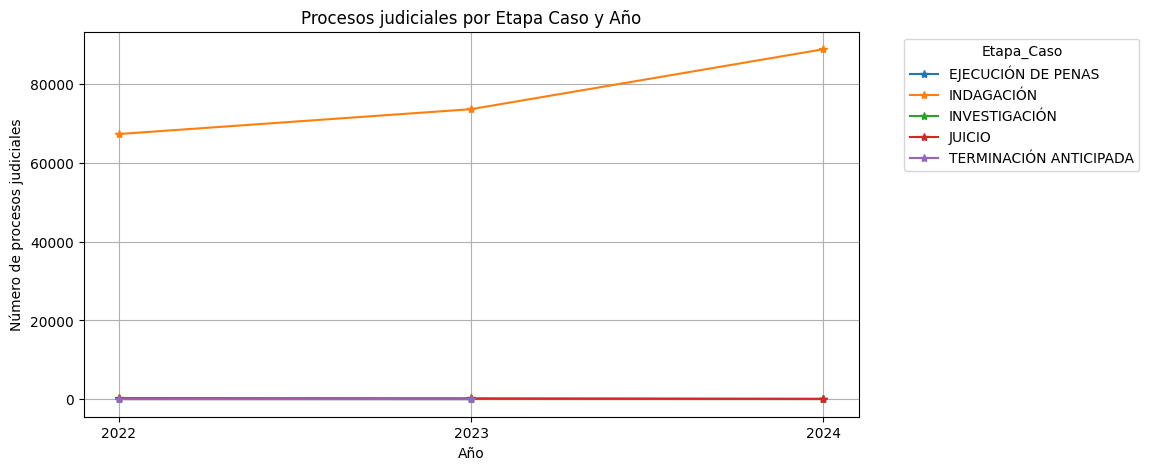

In [ ]:
# Gráfico con plt.bar(x, y, etiqueta, color/transparencia)
df_grafico_5 = df_delitos
df_grafico_5 = pd.DataFrame(df_grafico_5)
df_grafico_5 = df_grafico_5.groupby(['Etapa_Caso', 'Año_Hechos'], as_index=False)['total_procesos'].sum()

# Crear el gráfico
plt.figure(figsize=(10, 5))

# Ciclo para trazar por departamento
for dept in df_grafico_5['Etapa_Caso'].unique():
    df_dept = df_grafico_5[df_grafico_5['Etapa_Caso'] == dept]
    plt.plot(df_dept['Año_Hechos'].astype(str), df_dept['total_procesos'], marker='*', label=dept)

# Configuración del gráfico
plt.title('Procesos judiciales por Etapa Caso y Año')
plt.xlabel('Año')
plt.ylabel('Número de procesos judiciales')
plt.legend(title='Etapa_Caso', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# **Número de procesos por año y estado**

En esta línea se muestra la cantidad de procesos judiciales registrados por año, diferenciando su estado actual como activo o inactivo. Para su construcción, se agruparon los datos por año del hecho y estado del proceso, contando el total de registros en cada categoría. La visualización permite observar el comportamiento de los procesos en el tiempo, evidenciando una mayor proporción de procesos inactivos, aunque con tendencia a la baja, y de un ascenso año tras año de los procesoa activos.  

/tmp/ipython-input-76-3544052626.py:7: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




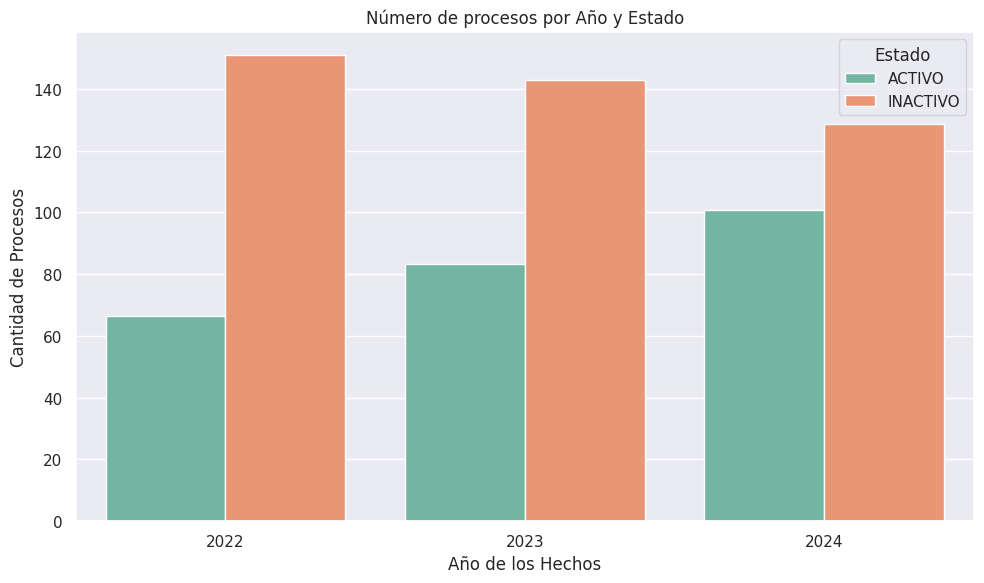

In [ ]:
# Agrupar y contar procesos
df_bar = df_delitos.groupby(['Año_Hechos', 'Departamento_Hecho', 'Estado'], as_index=False).size()
df_bar.rename(columns={'size': 'Cantidad_Procesos'}, inplace=True)

# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_bar,
    x='Año_Hechos',
    y='Cantidad_Procesos',
    hue='Estado',
    ci=None,
    palette='Set2'
)

plt.title('Número de procesos por Año y Estado')
plt.xlabel('Año de los Hechos')
plt.ylabel('Cantidad de Procesos')
plt.legend(title='Estado')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

\# **Número de procesos por año en etapa de indagación**

/tmp/ipython-input-85-2176735604.py:12: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




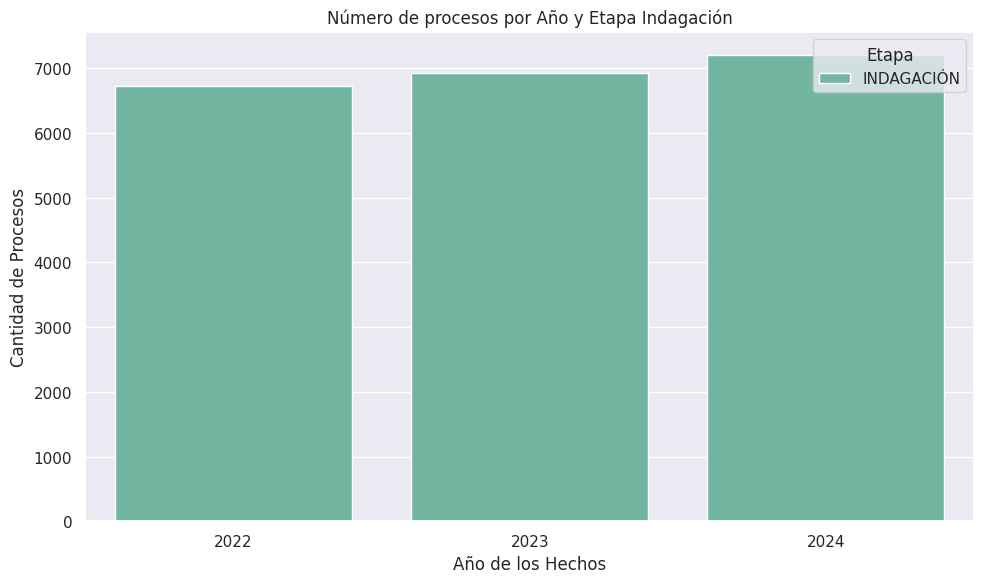

In [ ]:
# Filtrar el DataFrame para eliminar las filas donde 'Departamento' sea 'BOGOTA'
df_grafico_8 = df_delitos[df_delitos['Etapa_Caso'] == 'INDAGACIÓN']

#crear y agrupar el df
df_grafico_8 = df_grafico_8.groupby(['Año_Hechos', 'Etapa_Caso'], as_index=False).size()

# Renombrar la columna 'size' para que sea 'Cantidad_Procesos'
df_grafico_8.rename(columns={'size': 'Cantidad_Procesos'}, inplace=True)

# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_grafico_8,
    x='Año_Hechos',
    y='Cantidad_Procesos',
    hue='Etapa_Caso',
    ci=None,
    palette='Set2'
)

plt.title('Número de procesos por Año y Etapa Indagación')
plt.xlabel('Año de los Hechos')
plt.ylabel('Cantidad de Procesos')
plt.legend(title='Etapa')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Aquí se presenta la cantidad de procesos judiciales en la etapa de indagación entre los años 2022 y 2024. Para su construcción, se filtraron los datos exclusivamente para esta etapa y se agruparon por año, sumando el total de registros. La visualización muestra un aumento constante en el número de casos en esta fase inicial del proceso judicial, lo cual puede reflejar una mayor capacidad de detección, denuncia o registro de conductas delictivas en el tiempo. Esta información es útil para comprender la dinámica de entrada al sistema judicial y evaluar posibles cargas de trabajo en etapas preliminares.

# **Número de procesos por año en etapa de caso sin indagación**



/tmp/ipython-input-86-3783911282.py:12: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




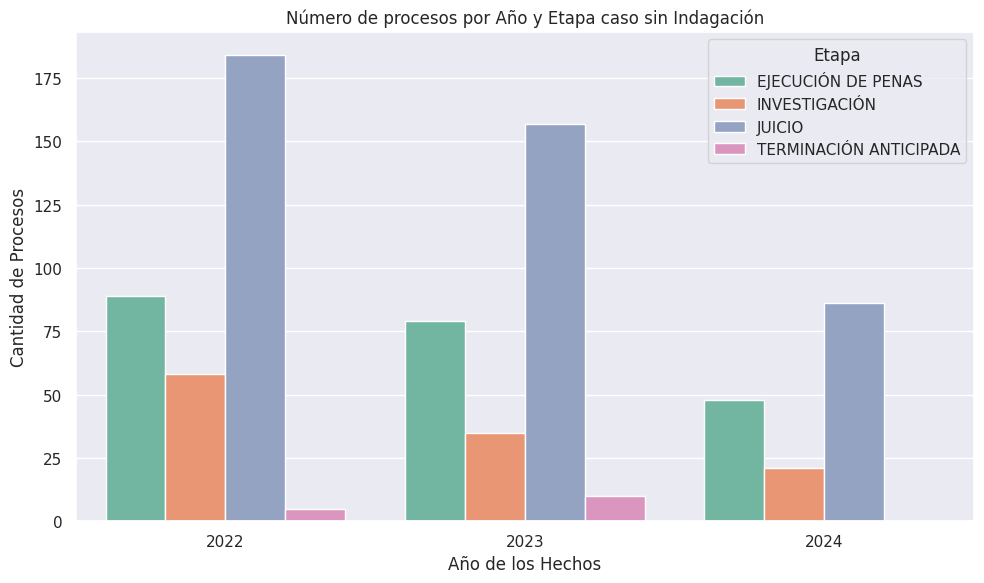

In [ ]:
# Filtrar el DataFrame para eliminar las filas donde 'Departamento' sea 'BOGOTA'
df_grafico_7 = df_delitos[df_delitos['Etapa_Caso'] != 'INDAGACIÓN']

#crear y agrupar el df
df_grafico_7 = df_grafico_7.groupby(['Año_Hechos', 'Etapa_Caso'], as_index=False).size()

# Renombrar la columna 'size' para que sea 'Cantidad_Procesos'
df_grafico_7.rename(columns={'size': 'Cantidad_Procesos'}, inplace=True)

# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_grafico_7,
    x='Año_Hechos',
    y='Cantidad_Procesos',
    hue='Etapa_Caso',
    ci=None,
    palette='Set2'
)

plt.title('Número de procesos por Año y Etapa caso sin Indagación')
plt.xlabel('Año de los Hechos')
plt.ylabel('Cantidad de Procesos')
plt.legend(title='Etapa')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

##*Se deja Indagación por fuera de este gráfico, puesto que sus datos son demasiado grandes con respecto al resto de los Departamentos*
El gráfico permite visualizar que la mayoría de los procesos en los periodos evaluados, después de la etapa de indagación, se encuentran en estado de  juzgamiento. Ahora, el estado de juzgamiento tiende a la baja.


# **Procesos judiciales por departamento y año**

Este gráfico de líneas muestra la evolución del número total de procesos judiciales por departamento entre los años 2022 y 2024. Para su construcción, los datos fueron agrupados por departamento y año, sumando la cantidad total de procesos registrados en cada combinación. La visualización permite identificar patrones de crecimiento o estabilidad a nivel territorial, resaltando departamentos con más procesos como Bogotá D.C. y Antioquia. Asimismo, se evidencian diferencias marcadas entre regiones, lo que puede reflejar variaciones en el acceso a la justicia. Esta información es clave para contextualizar el comportamiento de los procesos en el tiempo y orientar estrategias focalizadas en territorios con mayor demanda judicial.

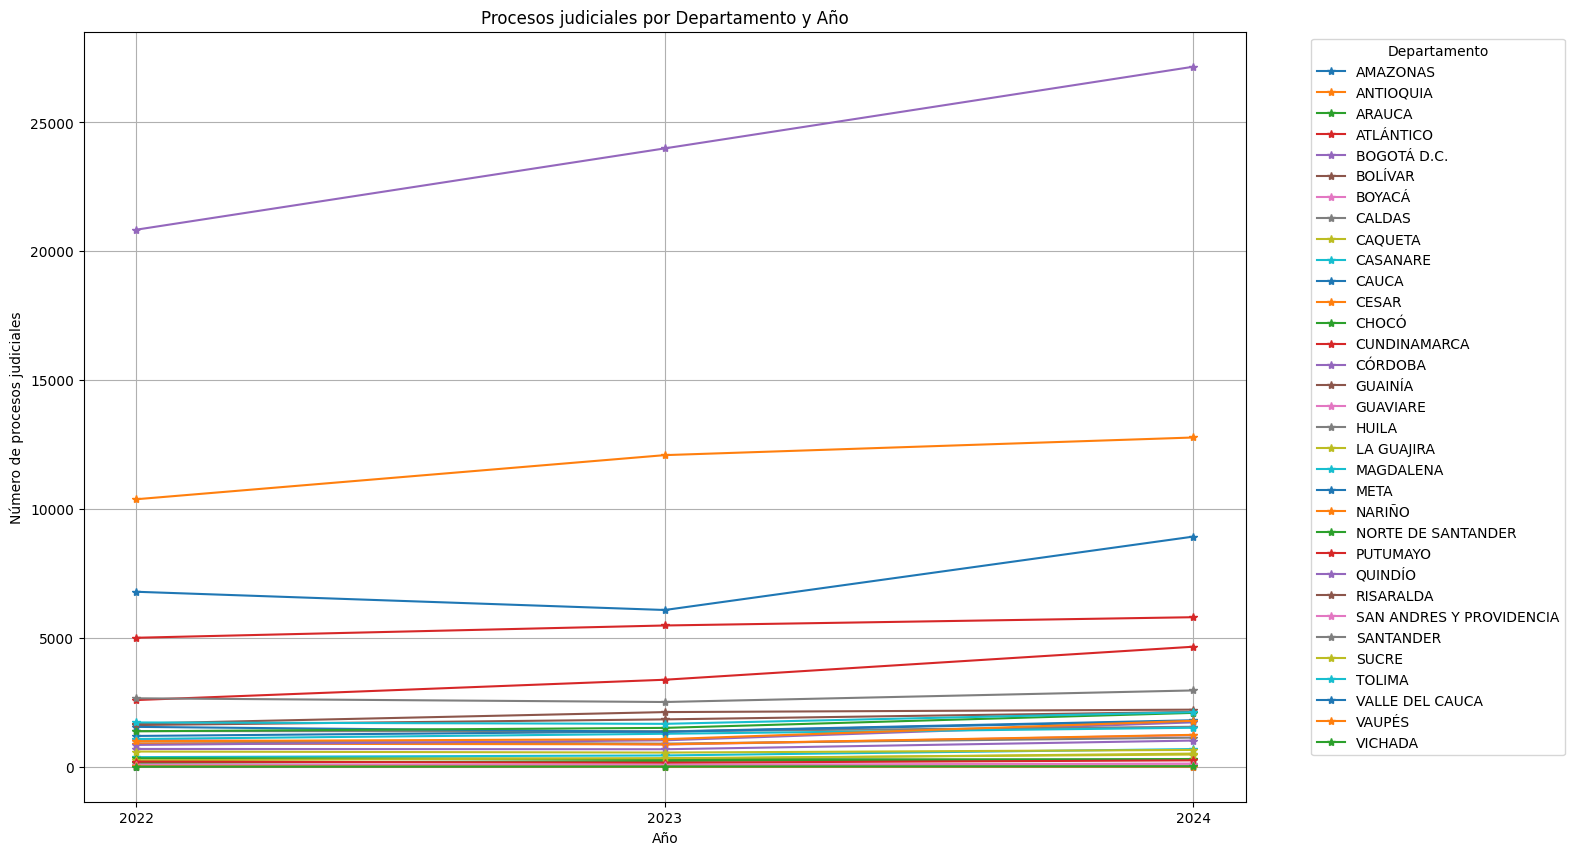

In [ ]:
# Crear el DataFrame
df_grafico_4 = df_union_cc_td.groupby(['Departamento', 'Año'], as_index=False).agg({'total_procesos': 'sum'})

# Crear el gráfico
plt.figure(figsize=(15, 10))

# Ciclo para trazar por departamento
for dept in df_grafico_4['Departamento'].unique():
    df_dept = df_grafico_4[df_grafico_4['Departamento'] == dept]
    plt.plot(df_dept['Año'].astype(str), df_dept['total_procesos'], marker='*', label=dept)

# Configuración del gráfico
plt.title('Procesos judiciales por Departamento y Año')
plt.xlabel('Año')
plt.ylabel('Número de procesos judiciales')
plt.legend(title='Departamento', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# **Conclusiones**

**Tendencia creciente y retos institucionales**: Hay un crecimiento sostenido en el número de procesos por delitos informáticos, el cual aumenta año tras año, con 2024 como punto más alto. Este repunte no solo refleja una mayor actividad de los ciberdelincuentes, sino que también pueda ser un indicio de que: a) los ciudadanos e instituciones han ganado mayor conocimiento y confianza para reportar, y b) los organismos judiciales, de investigación  y policiales han enfocado esfuerzos en la atención de esta clase de delirios; aunque aún pueden quedar rezagados en etapas de indagación, investigación y juzgamiento.

**Concentración territorial y brechas regionales**: Bogotá D.C., Antioquia, Valle del Cauca, Cundinamarca concentran la mayoría de procesos, probablemente porque tienen mayor población, mayor cantidad de personas con acceso a internet fijo y quizá mayor capacidad institucional para atender estos delitos. En un sentido contrario, los departamentos con menor conectividad presentan poco procesos, lo cual puede estar relacionado con el poco conocimiento para denunciar y la escasez de centros para realizar el reporte.

**Correlación población-conectividad-proceso**: Se halló un patrón claro: A mayor población y conexiones fijas, más procesos se registran. Por ejemplo, es lo que demuestra la relación entre la variables para Bogotá y para Antioquia para todos los periodos evaluados.

**Distribución sesgada(asimetría positiva)**: Pocos departamentos con cifras muy altas para las tres variables fundamentales (población, números de procesos y conexiones a internet. La mayoría de los departamentos, tienen valores muy bajos. Este análisis pone de presente que se deben evitar modelos predictivos dominados por grandes centros urbanos como Bogotá y Antioquia.

**Estado procesal y cuellos de botella**: Se tuvieron los siguientes hallazgos:  a) Indagación en ascenso: La mayoría de casos permanece en esa etapa y crece con el tiempo, b) Procesos activos vs. inactivos: Aunque hay más inactivos, su proporción disminuye; los activos van en aumento, c) Juzgamiento en retroceso tras indagación: Indica demoras o desestimaciones al pasar a juicio, y d) Implicaciones legales: Posible saturación de las salas de instrucción o falta de pruebas digitales sólidas para avanzar a juicio.
